# Quantizing a model with Post Training Static Quantization with Intel Neural Compressor (INC) for text to image tasks

This notebook shows how to apply post training quantization, using the Intel Neural Compressor (INC) library, for text to image tasks. This is made possible thanks to 🤗 Optimum Intel, an extension of 🤗 Transformers, providing a set of performance optimization tools enabling maximum efficiency to accelerate end-to-end pipelines on a variety of Intel processors.

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers, 🤗 Datasets, 🤗 Diffusers and 🤗 Optimum.

In [1]:
#! pip install datasets transformers optimum[neural-compressor]

The following example applies post-training static quantization on a stable diffusion modelfine-tuned on Pokémon. In this example, we only quantize the unet model which is the performance critical in the diffusion pipeline, the diffusion pipeline has four models: safety_checker, text_encoder, unet, vae

In [2]:
import argparse
import logging
import math
import os
import sys
import time

import torch
from accelerate.utils import set_seed
from diffusers import StableDiffusionPipeline
from neural_compressor import PostTrainingQuantConfig
from PIL import Image
from pytorch_fid import fid_score
from torch.utils.data import Dataset

from optimum.intel import INCQuantizer, INCStableDiffusionPipeline
from optimum.intel.utils.constant import DIFFUSION_WEIGHTS_NAME

In [3]:
def image_grid(imgs, rows, cols):
    if not len(imgs) == rows * cols:
        raise ValueError("The specified number of rows and columns are not correct.")

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [4]:
def benchmark(pipeline, generator):
    warmup = 1
    total = 3
    num_inference_steps = 10
    total_time = 0
    with torch.no_grad():
        for i in range(total):
            prompt = "a photo of an astronaut riding a horse on mars"
            start2 = time.time()
            pipeline(prompt, guidance_scale=7.5, num_inference_steps=num_inference_steps, generator=generator).images
            end2 = time.time()
            if i >= warmup:
                total_time += end2 - start2
            print("Total inference latency: ", str(end2 - start2) + "s")
    print("Average latency: ", (total_time) / (total - warmup), "s")

In [5]:
pipeline = StableDiffusionPipeline.from_pretrained("lambdalabs/sd-pokemon-diffusers")

vae/diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [6]:
name = "unet"
calibration_text = "a drawing of a gray and black dragon"
num_images_per_prompt = 1
num_inference_steps = 5
output_dir = "output_static/"
seed = 666
base_images = "base_images/"
_rows = int(math.sqrt(num_images_per_prompt))
generator = torch.Generator("cpu").manual_seed(seed)
                                               
def get_fp32_images():
    tmp_fp32_images = "tmp_fp32_images"
    os.makedirs(tmp_fp32_images, exist_ok=True)
    outputs = pipeline(
        calibration_text,
        guidance_scale=7.5,
        num_inference_steps=num_inference_steps,
        generator=generator,
        num_images_per_prompt=num_images_per_prompt,
    )
    fp32_images = outputs.images
    grid = image_grid(fp32_images, rows=_rows, cols=num_images_per_prompt // _rows)
    grid.save(os.path.join(tmp_fp32_images, "fp32.png"))
    return grid

def calibration_func(model):
    calib_num = 5
    setattr(pipeline, name, model)
    with torch.no_grad():
        for i in range(calib_num):
            pipeline(
                calibration_text,
                guidance_scale=7.5,
                num_inference_steps=num_inference_steps,
                generator=generator,
                num_images_per_prompt=num_images_per_prompt,
            )

def eval_func(model):
    setattr(pipeline, name, model)
    generator = torch.Generator("cpu").manual_seed(seed)
    tmp_int8_images = "tmp_int8_images"
    os.makedirs(tmp_int8_images, exist_ok=True)
    with torch.no_grad():
        new_images = pipeline(
            calibration_text,
            guidance_scale=7.5,
            num_inference_steps=num_inference_steps,
            generator=generator,
            num_images_per_prompt=num_images_per_prompt,
        ).images
        if os.path.isfile(os.path.join(tmp_int8_images, "int8.png")):
            os.remove(os.path.join(tmp_int8_images, "int8.png"))
        grid = image_grid(new_images, rows=_rows, cols=num_images_per_prompt // _rows)
        grid.save(os.path.join(tmp_int8_images, "int8.png"))
        fid = fid_score.calculate_fid_given_paths((base_images, tmp_int8_images), 1, "cpu", 2048, 8)
        return grid, fid

  0%|          | 0/5 [00:00<?, ?it/s]

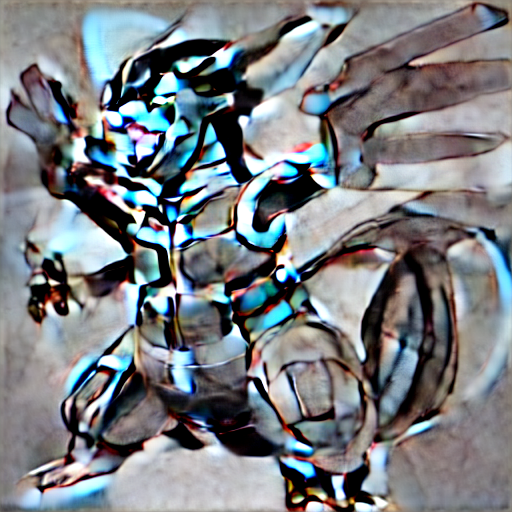

In [7]:
get_fp32_images()

In [8]:
# Create the quantization configuration containing all the quantization parameters
quantization_config = PostTrainingQuantConfig(approach="static") # static or dynamic

pipeline.save_pretrained(output_dir)

# Create a quantizer
quantizer = INCQuantizer.from_pretrained(pipeline.unet, calibration_fn=calibration_func)

In [9]:
from utils import CalibDataset
quantizer.quantize(
        quantization_config=quantization_config,
        save_directory=os.path.join(output_dir, "unet"),
        calibration_dataset=CalibDataset(),
        remove_unused_columns=False,
        file_name=DIFFUSION_WEIGHTS_NAME,
    )

2023-06-10 06:46:31 [INFO] Start auto tuning.
2023-06-10 06:46:31 [INFO] Execute the tuning process due to detect the evaluation function.
2023-06-10 06:46:31 [INFO] Adaptor has 4 recipes.
2023-06-10 06:46:31 [INFO] 0 recipes specified by user.
2023-06-10 06:46:31 [INFO] 3 recipes require future tuning.
2023-06-10 06:46:31 [INFO] *** Initialize auto tuning
2023-06-10 06:46:31 [INFO] {
2023-06-10 06:46:31 [INFO]     'PostTrainingQuantConfig': {
2023-06-10 06:46:31 [INFO]         'AccuracyCriterion': {
2023-06-10 06:46:31 [INFO]             'criterion': 'relative',
2023-06-10 06:46:31 [INFO]             'higher_is_better': True,
2023-06-10 06:46:31 [INFO]             'tolerable_loss': 0.01,
2023-06-10 06:46:31 [INFO]             'absolute': None,
2023-06-10 06:46:31 [INFO]             'keys': <bound method AccuracyCriterion.keys of <neural_compressor.config.AccuracyCriterion object at 0x7fe4fdbbe310>>,
2023-06-10 06:46:31 [INFO]             'relative': 0.01
2023-06-10 06:46:31 [INFO]    

  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
2023-06-10 06:48:06 [INFO] |*********Mixed Precision Statistics********|
2023-06-10 06:48:06 [INFO] +---------------------+-------+------+------+
2023-06-10 06:48:06 [INFO] |       Op Type       | Total | INT8 | FP32 |
2023-06-10 06:48:06 [INFO] +---------------------+-------+------+------+
2023-06-10 06:48:06 [INFO] | quantize_per_tensor |  282  | 282  |  0   |
2023-06-10 06:48:06 [INFO] |        Conv2d       |   98  |  98  |  0   |
2023-06-10 06:48:06 [INFO] |      dequantize     |  282  | 282  |  0   |
2023-06-10 06:48:06 [INFO] |        Linear       |  184  | 184  |  0   |
2023-06-10 06:48:06 [INFO] |      GroupNorm      |   61  |  0   |  61  |
2023-06-10 06:48:06 [INFO] |      LayerNorm      |   48  |  0   |  48  |
2023-06-10 06:48:06 [INFO] +---------------------+-------+------+------+
2023-06-10 06:48:06 [INFO] Pass quantize model elap

In [10]:
# Create pipeline using the Quantized Model
int8_pipeline = INCStableDiffusionPipeline.from_pretrained(output_dir)

grid, result_optimized_model = eval_func(quantizer._quantized_model)
grid, result_loaded_model = eval_func(int8_pipeline.unet)
if result_loaded_model != result_optimized_model:
    print("The quantized model was not successfully loaded.")
else:
    print("The quantized model was successfully loaded.")

/home/ubuntu/miniconda2/envs/optimum/lib/python3.8/site-packages/torch/_utils.py:343: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,
Some weights of the model checkpoint at output_static/unet were not used when initializing UNet2DConditionModel: ['down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_k.module_input_zero_point_0', 'up_blocks.2.attentions.2.transformer_blocks.0.attn1.to_q.module._packed_params.dtype', 'up_blocks.0.resnets.0.time_emb_proj.module._packed_params._packed_params', 'up_blocks.3.resnets.0.conv_shortcut.module.scale', 'up_blocks.3.attentions.2.proj_in.module.bias', 'up_blocks.3.attentions.2.transformer_blocks.0.attn1.to_k.module._packed_params._packed_params', 'down_blocks.1.attentions.0.proj_in.modul

Some weights of UNet2DConditionModel were not initialized from the model checkpoint at output_static/unet and are newly initialized: ['up_blocks.3.resnets.1.time_emb_proj.bias', 'up_blocks.3.resnets.1.norm1.bias', 'up_blocks.3.attentions.0.transformer_blocks.0.ff.net.0.proj.bias', 'up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_out.0.bias', 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_v.weight', 'down_blocks.2.attentions.1.transformer_blocks.0.attn1.to_q.weight', 'up_blocks.3.attentions.2.proj_in.bias', 'up_blocks.2.attentions.1.proj_out.weight', 'up_blocks.0.upsamplers.0.conv.bias', 'up_blocks.1.attentions.0.proj_in.bias', 'up_blocks.2.resnets.0.conv_shortcut.weight', 'up_blocks.2.attentions.0.transformer_blocks.0.attn2.to_q.weight', 'up_blocks.1.attentions.2.transformer_blocks.0.attn1.to_out.0.bias', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight', 'up_blocks.1.resnets.0.conv2.bias', 'up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.we

loading configuration file output_static/unet/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.2",
  "optimum_version": "1.8.6",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": 1,
    "is_static": true
  },
  "save_onnx_model": false,
  "torch_version": "2.1.0.dev20230609+cpu",
  "transformers_version": "4.30.1"
}

/home/ubuntu/miniconda2/envs/optimum/lib/python3.8/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

The quantized model was successfully loaded.


## Benchmarking

In [11]:
benchmark(pipeline, generator)

  0%|          | 0/10 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Total inference latency:  16.310590744018555s


  0%|          | 0/10 [00:00<?, ?it/s]

Total inference latency:  16.330223321914673s


  0%|          | 0/10 [00:00<?, ?it/s]

Total inference latency:  16.180222034454346s
Average latency:  16.25522267818451 s


In [12]:
int8_pipeline = INCStableDiffusionPipeline.from_pretrained(output_dir)
benchmark(int8_pipeline, generator)

Some weights of the model checkpoint at output_static/unet were not used when initializing UNet2DConditionModel: ['down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_k.module_input_zero_point_0', 'up_blocks.2.attentions.2.transformer_blocks.0.attn1.to_q.module._packed_params.dtype', 'up_blocks.0.resnets.0.time_emb_proj.module._packed_params._packed_params', 'up_blocks.3.resnets.0.conv_shortcut.module.scale', 'up_blocks.3.attentions.2.proj_in.module.bias', 'up_blocks.3.attentions.2.transformer_blocks.0.attn1.to_k.module._packed_params._packed_params', 'down_blocks.1.attentions.0.proj_in.module_input_zero_point_0', 'up_blocks.2.resnets.0.conv1.module.bias', 'up_blocks.1.attentions.0.transformer_blocks.0.ff.net.2.module.zero_point', 'up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_k.module._packed_params._packed_params', 'up_blocks.2.resnets.0.conv_shortcut.module.zero_point', 'down_blocks.2.downsamplers.0.conv.module.bias', 'up_blocks.2.attentions.1.transformer_blocks.0.attn

Some weights of UNet2DConditionModel were not initialized from the model checkpoint at output_static/unet and are newly initialized: ['up_blocks.3.resnets.1.time_emb_proj.bias', 'up_blocks.3.resnets.1.norm1.bias', 'up_blocks.3.attentions.0.transformer_blocks.0.ff.net.0.proj.bias', 'up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_out.0.bias', 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_v.weight', 'down_blocks.2.attentions.1.transformer_blocks.0.attn1.to_q.weight', 'up_blocks.3.attentions.2.proj_in.bias', 'up_blocks.2.attentions.1.proj_out.weight', 'up_blocks.0.upsamplers.0.conv.bias', 'up_blocks.1.attentions.0.proj_in.bias', 'up_blocks.2.resnets.0.conv_shortcut.weight', 'up_blocks.2.attentions.0.transformer_blocks.0.attn2.to_q.weight', 'up_blocks.1.attentions.2.transformer_blocks.0.attn1.to_out.0.bias', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight', 'up_blocks.1.resnets.0.conv2.bias', 'up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.we

loading configuration file output_static/unet/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.2",
  "optimum_version": "1.8.6",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": 1,
    "is_static": true
  },
  "save_onnx_model": false,
  "torch_version": "2.1.0.dev20230609+cpu",
  "transformers_version": "4.30.1"
}



  0%|          | 0/10 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Total inference latency:  12.990246295928955s


  0%|          | 0/10 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Total inference latency:  13.002135753631592s


  0%|          | 0/10 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Total inference latency:  13.050612688064575s
Average latency:  13.026374220848083 s
